# Reference model - test set: age
# Table of contents 
1. [Linear Regression](#LinearRegression)
2. [MLP (Dense)](#MLP)
3. [AE combined latent](#AE_combined)
4. [AE OTU latent](#AE_latentOTU)

In [1]:
from data import *
from transfer_learning import *
from test_functions import *
from layers import *
from utils import *
from loss import *
from metric import *
from results import *
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

Using TensorFlow backend.


In [2]:
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = \
    read_df_with_transfer_learning_subset_fewerDomainFeatures(['age'])

In [3]:
print(df_domain_train.shape)
print(df_domain_test.shape)

(4251, 1)
(373, 1)


In [4]:
print('TRAIN:')
print('age:' + str(df_domain_train.loc[:,'age'].mean()))
#print('Temperature:' + str(df_domain_train.loc[:,'Temperature'].mean()))
    
print('TEST:')
print('age:' + str(df_domain_test.loc[:,'age'].mean()))
#print('Temperature:' + str(df_domain_test.loc[:,'Temperature'].mean()))

TRAIN:
age:9.131498470948012
TEST:
age:9.091152815013405


### Get numpy transfer_learning objects

In [5]:
data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

# 1. Linear regression <a name="LinearRegression"></a>

In [6]:
def model(shape_in, shape_out, output_transform):
    in_layer = layers.Input(shape=(shape_in,))
    net = in_layer
    net = layers.Dense(shape_out, activation='linear')(net)
    if output_transform is not None:
        net = output_transform(net)
    out_layer = net
    
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    return model

def compile_model(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

In [7]:
def model_fn():
    m = model(shape_in=1,
              shape_out=717,
              output_transform=None)
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.001),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio(),
                  output_transform=None)
    return m, None, m, None

In [8]:
latent_space = 0
results, modelsLR = train(model_fn,
                        data_microbioma_train,
                        data_domain_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>99</b></p>

<b>loss</b>: 4.1253 (min: 4.1148, max: 4.1386)

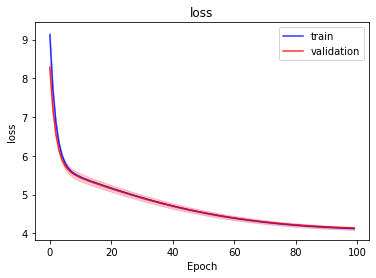

<b>domain_BrayCurtis</b>: 0.4682 (min: 0.4665, max: 0.4693)

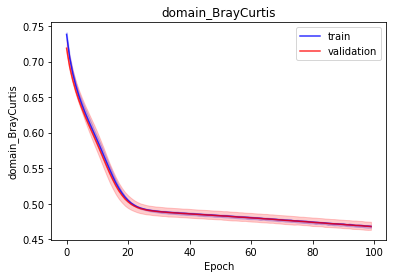

<b>domain_pearson_corr</b>: 0.6757 (min: 0.6716, max: 0.6778)

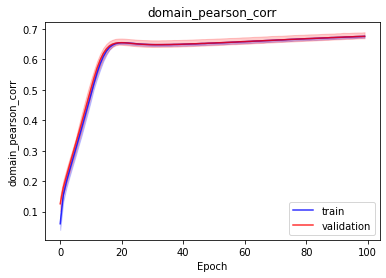

<b>domain_jensen_shannon_divergence</b>: 1.0897 (min: 1.0749, max: 1.0973)

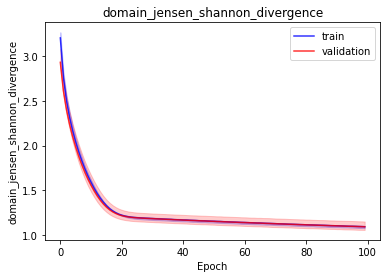

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 4.125343401488804 | 4.1148118217774465 | 4.138566422181971 |
| domain_BrayCurtis | 0.4681861996650696 | 0.4664541482925415 | 0.46929919719696045 |
| domain_pearson_corr | 0.6757315993309021 | 0.671629011631012 | 0.6778249740600586 |
| domain_jensen_shannon_divergence | 1.089735746383667 | 1.074852705001831 | 1.0972684621810913 |


[('best_lost_epoch', 99),
 ('val_loss', [4.13515191078186, 4.087149279458182, 4.165681856019156]),
 ('val_domain_BrayCurtis', [0.46806717, 0.46338755, 0.474665]),
 ('val_domain_pearson_corr', [0.67571133, 0.66900814, 0.6890858]),
 ('val_domain_jensen_shannon_divergence', [1.0895684, 1.0538107, 1.1483672])]

In [9]:
print_results(results)

In [10]:
predictions = test_model(modelsLR, CenterLogRatio, None, data_microbioma_test, data_domain_test)
#save_predictions(predictions, 'experiment_testSet_linear_regresion_age.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.47698402404785156 | 0.47646665573120117 | 0.47758787870407104 |
| pearson_corr | 0.6605658531188965 | 0.6587381362915039 | 0.662034273147583 |
| jensen_shannon_divergence | 1.0742591619491577 | 1.072227954864502 | 1.0764192342758179 |


# 2. MLP (Dense) <a name="MLP"></a>

In [11]:
def model(shape_in, shape_out, output_transform, layers_list, activation_fn):
    in_layer = layers.Input(shape=(shape_in,))
    net = in_layer
    for s in layers_list:
        net = layers.Dense(s, activation=activation_fn)(net)
    net = layers.Dense(shape_out, activation='linear')(net)
    if output_transform is not None:
        net = output_transform(net)
    out_layer = net
    
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    return model

def compile_model(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

In [12]:
def model_fn():
    m = model(shape_in=1,
              shape_out=717,
              output_transform=None,
              layers_list=[128,512],
              activation_fn='tanh')
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.01),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio(),
                  output_transform=None)
    return m, None, m, None

In [13]:
latent_space=0
results, modelsMLP = train(model_fn,
                        data_microbioma_train,
                        data_domain_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>65</b></p>

<b>loss</b>: 3.8619 (min: 3.8256, max: 3.9007)

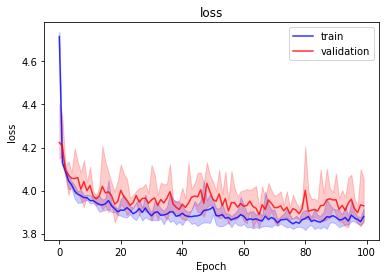

<b>domain_BrayCurtis</b>: 0.4193 (min: 0.4131, max: 0.4235)

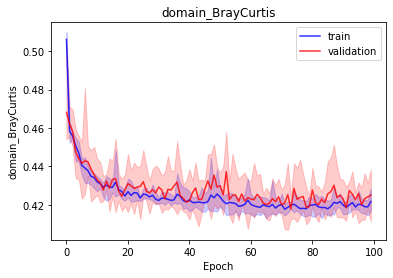

<b>domain_pearson_corr</b>: 0.7193 (min: 0.7156, max: 0.7244)

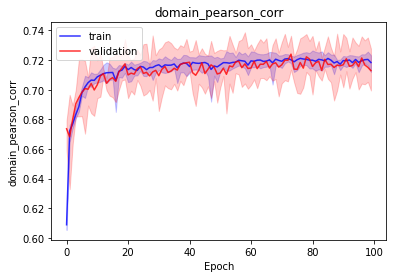

<b>domain_jensen_shannon_divergence</b>: 0.9112 (min: 0.8820, max: 0.9350)

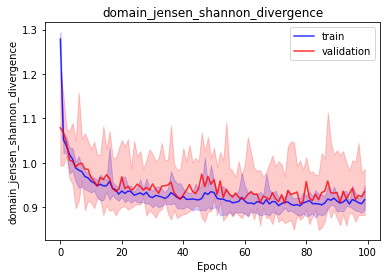

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 3.861949953094926 | 3.8255701785717107 | 3.9007220493979538 |
| domain_BrayCurtis | 0.4193360209465027 | 0.4130561351776123 | 0.42350104451179504 |
| domain_pearson_corr | 0.7193163633346558 | 0.7155715227127075 | 0.724409282207489 |
| domain_jensen_shannon_divergence | 0.9111723899841309 | 0.88201904296875 | 0.9350450038909912 |


[('best_lost_epoch', 65),
 ('val_loss', [3.888057698522295, 3.8288608959742954, 3.9231014592306956]),
 ('val_domain_BrayCurtis', [0.42011482, 0.41253603, 0.42882395]),
 ('val_domain_pearson_corr', [0.71911514, 0.7064062, 0.73476064]),
 ('val_domain_jensen_shannon_divergence', [0.9103869, 0.85929614, 0.9836616])]

In [14]:
print_results(results)

In [15]:
predictions = test_model(modelsMLP, CenterLogRatio, None, data_microbioma_test, data_domain_test)
#save_predictions(predictions, 'experiment_testSet_MLP_age.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.4284992218017578 | 0.4173041582107544 | 0.44733405113220215 |
| pearson_corr | 0.7076746225357056 | 0.6862063407897949 | 0.724258542060852 |
| jensen_shannon_divergence | 0.8863344192504883 | 0.852087676525116 | 0.9651034474372864 |


# 3. Auto-encoder combined latent <a name="AE_combined"></a>

In [16]:
from train_2 import *

### Get microbioma train data and numpy train objects

In [17]:
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = \
    read_df_with_transfer_learning_subset_fewerDomainFeatures(['age'])

In [18]:
data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

In [19]:
data_domain_train.shape

(4251, 1)

### To create auto-encoder combined model

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 10 |
| Bioma Autoencoder | b -> 512 -> 256 -> 10 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 10 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 5 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>92</b></p>

<b>loss</b>: 0.6331 (min: 0.6247, max: 0.6544)

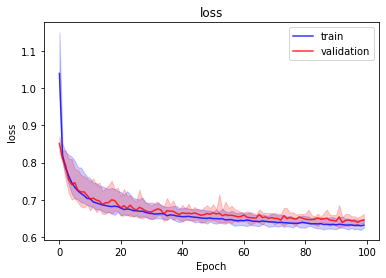

<b>bioma_loss</b>: 0.1952 (min: 0.1893, max: 0.2112)

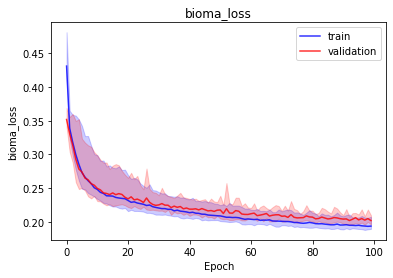

<b>domain_loss</b>: 0.4180 (min: 0.4154, max: 0.4207)

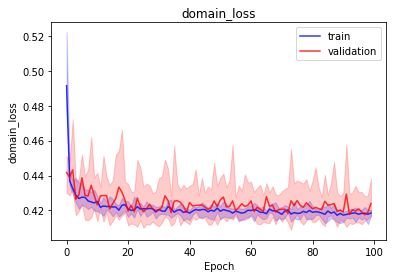

<b>latent_loss</b>: 0.0189 (min: 0.0177, max: 0.0220)

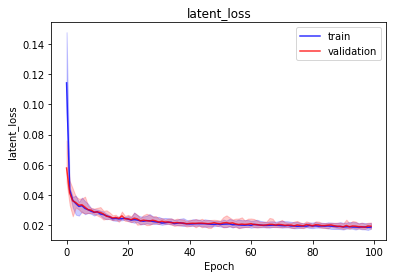

<b>bioma_mse</b>: 0.0000 (min: 0.0000, max: 0.0000)

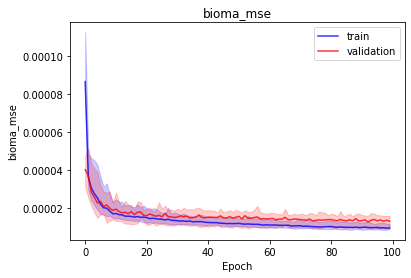

<b>bioma_mae</b>: 0.0005 (min: 0.0005, max: 0.0006)

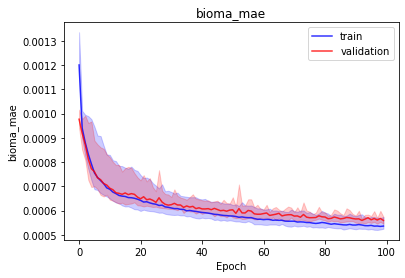

<b>bioma_mape</b>: 4737.8828 (min: 4447.3154, max: 5229.1055)

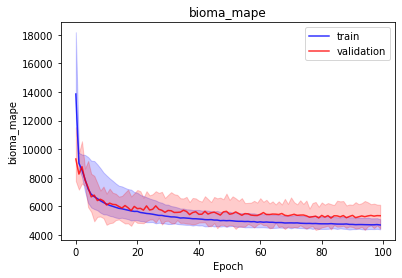

<b>bioma_BrayCurtis</b>: 0.1958 (min: 0.1901, max: 0.2117)

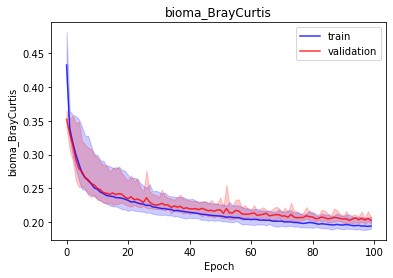

<b>bioma_pearson_corr</b>: 0.9281 (min: 0.9154, max: 0.9330)

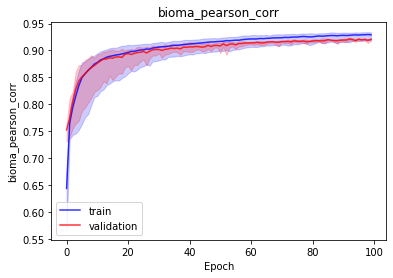

<b>bioma_jensen_shannon_divergence</b>: 0.3309 (min: 0.3108, max: 0.3682)

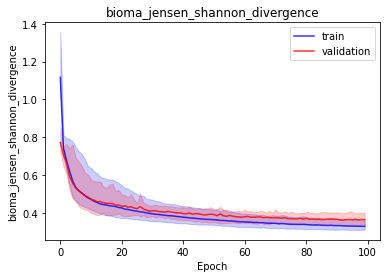

<b>domain_mse</b>: 0.0001 (min: 0.0001, max: 0.0001)

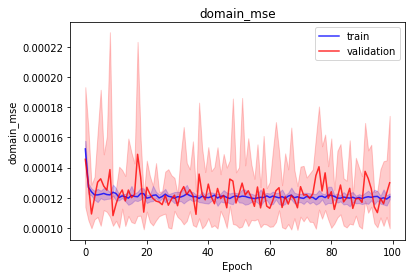

<b>domain_mae</b>: 0.0012 (min: 0.0012, max: 0.0012)

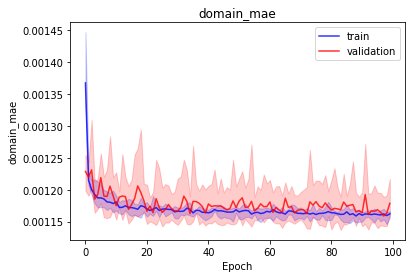

<b>domain_mape</b>: 8219.0889 (min: 8064.8652, max: 8397.6826)

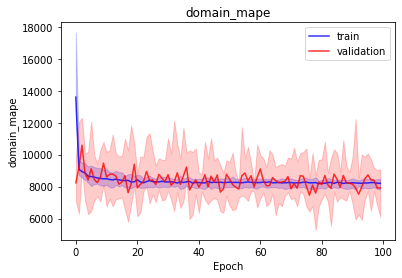

<b>domain_BrayCurtis</b>: 0.4184 (min: 0.4168, max: 0.4206)

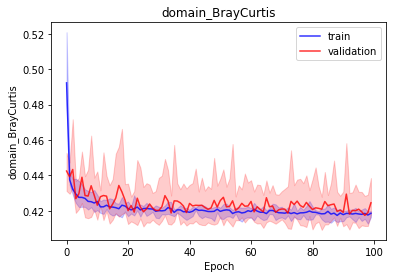

<b>domain_pearson_corr</b>: 0.7112 (min: 0.7070, max: 0.7136)

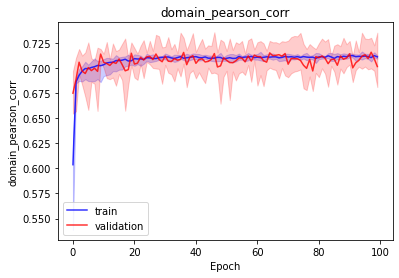

<b>domain_jensen_shannon_divergence</b>: 0.9292 (min: 0.9124, max: 0.9460)

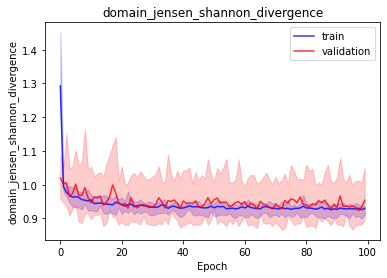

<b>latent_mae</b>: 0.0189 (min: 0.0178, max: 0.0220)

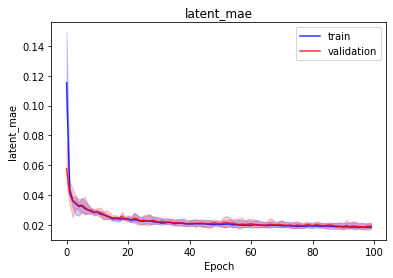

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.6331390862044289 | 0.6246938857216233 | 0.6543577337265014 |
| bioma_loss | 0.19521300494670868 | 0.18933545053005219 | 0.21123597025871277 |
| domain_loss | 0.41803616285324097 | 0.4154079556465149 | 0.420698881149292 |
| latent_loss | 0.018920619040727615 | 0.01774478890001774 | 0.022026780992746353 |
| bioma_mse | 9.974658496503253e-06 | 8.893903213902377e-06 | 1.2912899364891928e-05 |
| bioma_mae | 0.0005404101102612913 | 0.0005246178479865193 | 0.0005846057902090251 |
| bioma_mape | 4737.8828125 | 4447.3154296875 | 5229.10546875 |
| bioma_BrayCurtis | 0.19578154385089874 | 0.19006314873695374 | 0.21170876920223236 |
| bioma_pearson_corr | 0.9281331300735474 | 0.9153662919998169 | 0.932991087436676 |
| bioma_jensen_shannon_divergence | 0.3309415578842163 | 0.310800164937973 | 0.3681524395942688 |
| domain_mse | 0.00012066229101037607 | 0.0001159545499831438 | 0.00012468811473809183 |
| domain_mae | 0.001161674503237009 | 0.0011574223171919584 | 0.0011675488203763962 |
| domain_mape | 8219.0888671875 | 8064.865234375 | 8397.6826171875 |
| domain_BrayCurtis | 0.41842561960220337 | 0.4168427884578705 | 0.4206196963787079 |
| domain_pearson_corr | 0.7112036347389221 | 0.7069754004478455 | 0.7135584354400635 |
| domain_jensen_shannon_divergence | 0.9292065501213074 | 0.9123570919036865 | 0.9460123181343079 |
| latent_mae | 0.018931886181235313 | 0.01778785139322281 | 0.02202930673956871 |


*************

In [20]:
# Train the selected model (the best one from those with the smallest latent space (10)): no.351
experiment_metrics, models, results = perform_experiment_2(cv_folds=5, 
                        epochs=100, 
                        batch_size=64, 
                        learning_rate=0.001, 
                        optimizer=optimizers.Adam,
                        learning_rate_scheduler=None,
                        input_transform=Percentage,
                        output_transform=tf.keras.layers.Softmax,
                        reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None), 
                        latent_space=10, 
                        layers=[512,256],
                        activation='tanh', 
                        activation_latent='tanh', 
                        data_microbioma_train=data_microbioma_train,
                        data_domain_train=data_domain_train,
                        show_results=True, 
                        device='/CPU:0')

In [21]:
predictions = test_model_cv_predictions(models, Percentage, tf.keras.layers.Softmax, data_microbioma_test, data_domain_test)
#save_predictions(predictions, 'experiment_testSet_AE_combinedLatent_5CV_age.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.4189482629299164 | 0.4189482629299164 | 0.4189482629299164 |
| pearson_corr | 0.6944175362586975 | 0.6944175362586975 | 0.6944175362586975 |
| jensen_shannon_divergence | 0.8785697221755981 | 0.8785697221755981 | 0.8785697221755981 |


# 4. Auto-encoder OTU latent <a name="AE_latentOTU"></a>

In [22]:
from train_2 import *

### Get microbioma train data and numpy train objects

In [23]:
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = \
    read_df_with_transfer_learning_subset_fewerDomainFeatures(['age'])

In [24]:
data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

In [25]:
data_microbioma_train.shape

(4251, 717)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 10 |
| Bioma Autoencoder | b -> 512 -> 256 -> 10 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>99</b></p>

<b>loss</b>: 0.1631 (min: 0.1631, max: 0.1631)

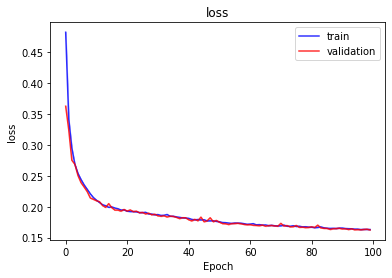

<b>bioma_mse</b>: 0.0000 (min: 0.0000, max: 0.0000)

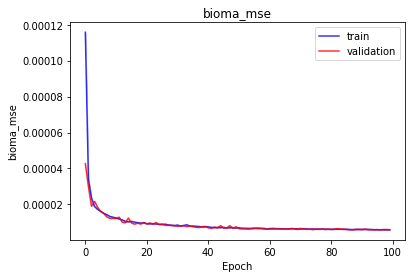

<b>bioma_mae</b>: 0.0004 (min: 0.0004, max: 0.0004)

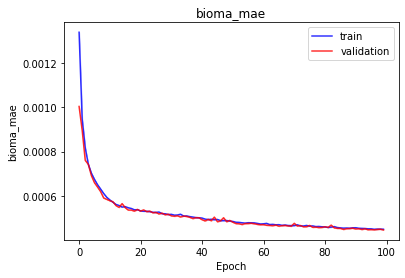

<b>bioma_mape</b>: 4060.0955 (min: 4060.0955, max: 4060.0955)

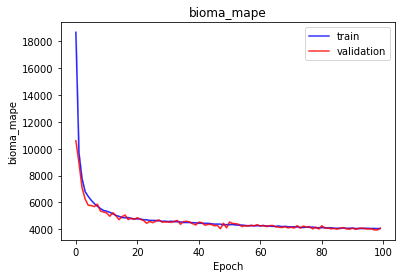

<b>bioma_BrayCurtis</b>: 0.1631 (min: 0.1631, max: 0.1631)

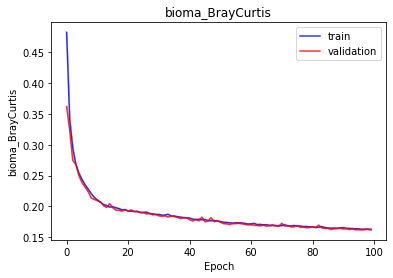

<b>bioma_pearson_corr</b>: 0.9495 (min: 0.9495, max: 0.9495)

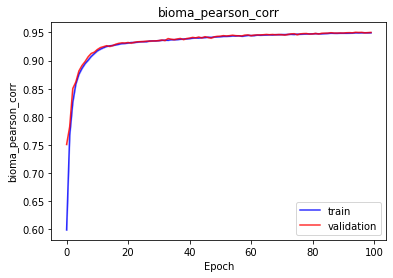

<b>bioma_jensen_shannon_divergence</b>: 0.2646 (min: 0.2646, max: 0.2646)

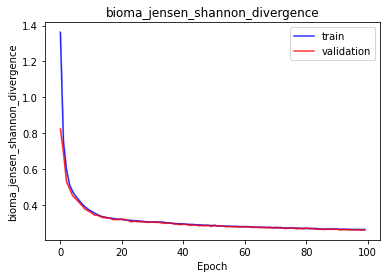

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.16313993290743248 | 0.16313993290743248 | 0.16313993290743248 |
| bioma_mse | 5.9371814131736755e-06 | 5.9371814131736755e-06 | 5.9371814131736755e-06 |
| bioma_mae | 0.00044932746095582843 | 0.00044932746095582843 | 0.00044932746095582843 |
| bioma_mape | 4060.095458984375 | 4060.095458984375 | 4060.095458984375 |
| bioma_BrayCurtis | 0.1631399542093277 | 0.1631399542093277 | 0.1631399542093277 |
| bioma_pearson_corr | 0.9494578838348389 | 0.9494578838348389 | 0.9494578838348389 |
| bioma_jensen_shannon_divergence | 0.264644593000412 | 0.264644593000412 | 0.264644593000412 |


*************

In [26]:
# Train the selected model (the best one from those with the smallest latent space (10)): no.351
experiment_metrics, models, results = perform_experiment_2(cv_folds=0, 
                        epochs=100, 
                        batch_size=64, 
                        learning_rate=0.001, 
                        optimizer=optimizers.Adam,
                        learning_rate_scheduler=None,
                        input_transform=Percentage,
                        output_transform=tf.keras.layers.Softmax,
                        reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None), 
                        latent_space=10, 
                        layers=[512,256],
                        activation='tanh', 
                        activation_latent='tanh', 
                        data_microbioma_train=data_microbioma_train,
                        data_domain_train=None,
                        show_results=True, 
                        device='/CPU:0')

### To get encoders and decoders to use in transfer learning model

In [27]:
model, encoder, _ ,decoder = models[0]

In [28]:
df_domain_train.shape

(4251, 1)

### To predict latent space for samples in domain->latent model

In [29]:
latent_train = encoder.predict(data_microbioma_train)
latent_test = encoder.predict(data_microbioma_test)

### To build model to predict latent space 

In [32]:
def model_fn_latent():
    in_layer = layers.Input(shape=(1,))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(64, activation='tanh')(net)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation=None)(net) # 'tanh already'
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [33]:
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                            latent_train,
                            latent_train,
                            data_domain_train,
                            data_domain_train,
                            epochs=100,
                            batch_size=16,
                            verbose=-1)

In [34]:
print_results_noEnsemble(result_latent)

<p>Best iteration: <b>51</b></p>

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.06193528947856174 | 0.06013454203026151 | 0.07583781277182046 |
| domain_mean_squared_error | 0.061935290694236755 | 0.06013454124331474 | 0.07583780586719513 |


In [35]:
# Test only Dense(domain->latent)
predictions = test_model_tl_latent(model_latent, latent_test, data_domain_test)
#save_predictions(predictions, 'experiment_testSet_domain-latent_AE_OTUlatent_age.txt)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| mse | 0.059585295617580414 | 2.3044934016613894e-10 | 1.0651291608810425 |


### Domain -> latent -> microbiome. Test set

In [36]:
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, data_microbioma_test, data_domain_test)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.4191700518131256 | 0.4191700518131256 | 0.4191700518131256 |
| pearson_corr | 0.7330431938171387 | 0.7330431938171387 | 0.7330431938171387 |
| jensen_shannon_divergence | 0.8646822571754456 | 0.8646822571754456 | 0.8646822571754456 |
